In [5]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
import seaborn as sns
from itertools import product
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
#from codes.regression import Regression

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

In [6]:
# Data downloaded from https://github.com/synbiochem/opt-mva
# Paper https://pubs.acs.org/doi/abs/10.1021/acssynbio.8b00398

# A: whole RBS sequence (len: 29)
# B: extracted 20-base RBS seqeunce (A[7:27], len: 20), training features
# C: TIR labels
# D: the design part RBS (B[7:13], len: 6) 

#Path = '../../data/First_round_results/Results - First Plate 3 reps.csv'
Path = '../../data/firstRound_4h_normFalse_formatSeq.csv'


df = pd.read_csv(Path)
df.head()

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,AVERAGE,STD
0,0,RBS_1by1_0,reference,TTTAAGAAGGAGATATACAT,AGGAGA,NaN,52.402431,NaN,61.622165,54.151485,56.058694,3.998246
1,1,RBS_1by1_1,bps_noncore,CTTAAGAAGGAGATATACAT,AGGAGA,NaN,40.072951,NaN,42.042854,45.432032,42.515946,2.213263
2,2,RBS_1by1_2,bps_noncore,GTTAAGAAGGAGATATACAT,AGGAGA,NaN,28.831559,NaN,24.487870,24.133637,25.817689,2.136029
3,3,RBS_1by1_3,bps_noncore,ATTAAGAAGGAGATATACAT,AGGAGA,NaN,43.093359,NaN,38.641958,38.049577,39.928298,2.251065
4,4,RBS_1by1_4,bps_noncore,TCTAAGAAGGAGATATACAT,AGGAGA,NaN,45.913214,NaN,44.352931,38.394865,42.887003,3.239660


In [7]:
df.sort_values(by = ['Rep3'], ascending = False).head(10)

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,AVERAGE,STD
115,138,RBS_BA_48,bandit,TTTAAGACTTTTTTATACAT,CTTTTT,54.782242,48.489185,61.284187,NaN,NaN,54.851871,5.223770
145,173,RBS_RP_54,prob random,TTTAAGATAGTCTTATACAT,TAGTCT,46.329777,43.329749,48.668344,NaN,NaN,46.109290,2.185042
114,137,RBS_BA_47,bandit,TTTAAGAGTTTTTTATACAT,GTTTTT,42.834915,41.799990,42.584558,NaN,NaN,42.406488,0.440870
128,152,RBS_RP_32,prob random,TTTAAGATGAGGGTATACAT,TGAGGG,32.562747,32.481046,37.260497,NaN,NaN,34.101430,2.234047
106,113,RBS_BA_23,bandit,TTTAAGAGGAAGATATACAT,GGAAGA,32.554581,35.053580,34.510295,NaN,NaN,34.039485,1.073156
123,147,RBS_BA_57,bandit,TTTAAGAGGATAATATACAT,GGATAA,32.930016,34.424821,30.885630,NaN,NaN,32.746822,1.450664
134,159,RBS_RP_39,prob random,TTTAAGACTAGGATATACAT,CTAGGA,37.415545,38.876886,30.743758,NaN,NaN,35.678730,3.540183
89,90,RBS_BA_00,bandit,TTTAAGACGGATTTATACAT,CGGATT,30.780532,30.442682,30.096818,NaN,NaN,30.440011,0.279131
141,169,RBS_RP_50,prob random,TTTAAGAAAAGTGTATACAT,AAAGTG,31.482938,33.145753,30.067898,NaN,NaN,31.565530,1.257885
132,157,RBS_RP_37,prob random,TTTAAGACGTGTGTATACAT,CGTGTG,29.597290,33.581536,29.481337,NaN,NaN,30.886721,1.906110


## Number of A or G in bandits design

Text(0, 0.5, 'Average label')

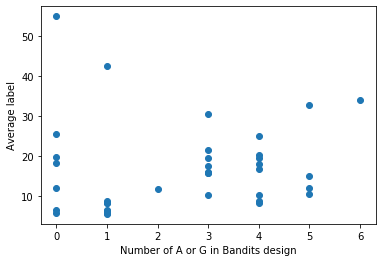

In [8]:
df_bandit = df[df['Group'] == 'bandit'][['RBS6', 'AVERAGE', 'STD']]
num_ags = []

for rbs6 in np.asarray(df_bandit['RBS6']):
    num = 0
    for i in rbs6:
        if i == 'A' or i == 'G':
            num+=1
    num_ags.append(num)
    
plt.scatter(num_ags, np.asarray(df_bandit['AVERAGE']))
plt.xlabel('Number of A or G in Bandits design')
plt.ylabel('Average label')

Text(0, 0.5, 'Number of sequences')

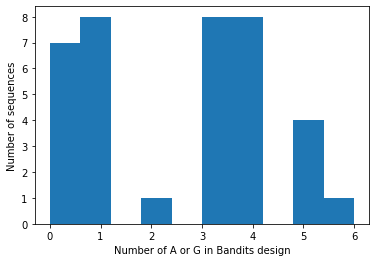

In [9]:
plt.hist(num_ags)
plt.xlabel('Number of A or G in Bandits design')
plt.ylabel('Number of sequences')

## Violinplot and swarmplot with AVERAGE value

In [10]:
df.sort_values(by = ['AVERAGE'], ascending = False).head(10)

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,AVERAGE,STD
0,0,RBS_1by1_0,reference,TTTAAGAAGGAGATATACAT,AGGAGA,NaN,52.402431,NaN,61.622165,54.151485,56.058694,3.998246
115,138,RBS_BA_48,bandit,TTTAAGACTTTTTTATACAT,CTTTTT,54.782242,48.489185,61.284187,NaN,NaN,54.851871,5.223770
59,60,RBS_1by1_60,bps_noncore,TTTAAGAAGGAGATATACAA,AGGAGA,NaN,43.183173,NaN,47.433874,48.048028,46.221691,2.163137
145,173,RBS_RP_54,prob random,TTTAAGATAGTCTTATACAT,TAGTCT,46.329777,43.329749,48.668344,NaN,NaN,46.109290,2.185042
47,48,RBS_1by1_48,bps_noncore,TTTAAGAAGGAGATAAACAT,AGGAGA,NaN,43.377297,NaN,49.202630,39.787620,44.122516,3.879615
4,4,RBS_1by1_4,bps_noncore,TCTAAGAAGGAGATATACAT,AGGAGA,NaN,45.913214,NaN,44.352931,38.394865,42.887003,3.239660
1,1,RBS_1by1_1,bps_noncore,CTTAAGAAGGAGATATACAT,AGGAGA,NaN,40.072951,NaN,42.042854,45.432032,42.515946,2.213263
114,137,RBS_BA_47,bandit,TTTAAGAGTTTTTTATACAT,GTTTTT,42.834915,41.799990,42.584558,NaN,NaN,42.406488,0.440870
10,11,RBS_1by1_11,bps_noncore,TTTGAGAAGGAGATATACAT,AGGAGA,NaN,44.897779,NaN,42.063149,39.304470,42.088466,2.283529
7,8,RBS_1by1_8,bps_noncore,TTGAAGAAGGAGATATACAT,AGGAGA,NaN,40.197744,NaN,45.233411,38.655693,41.362283,2.808761


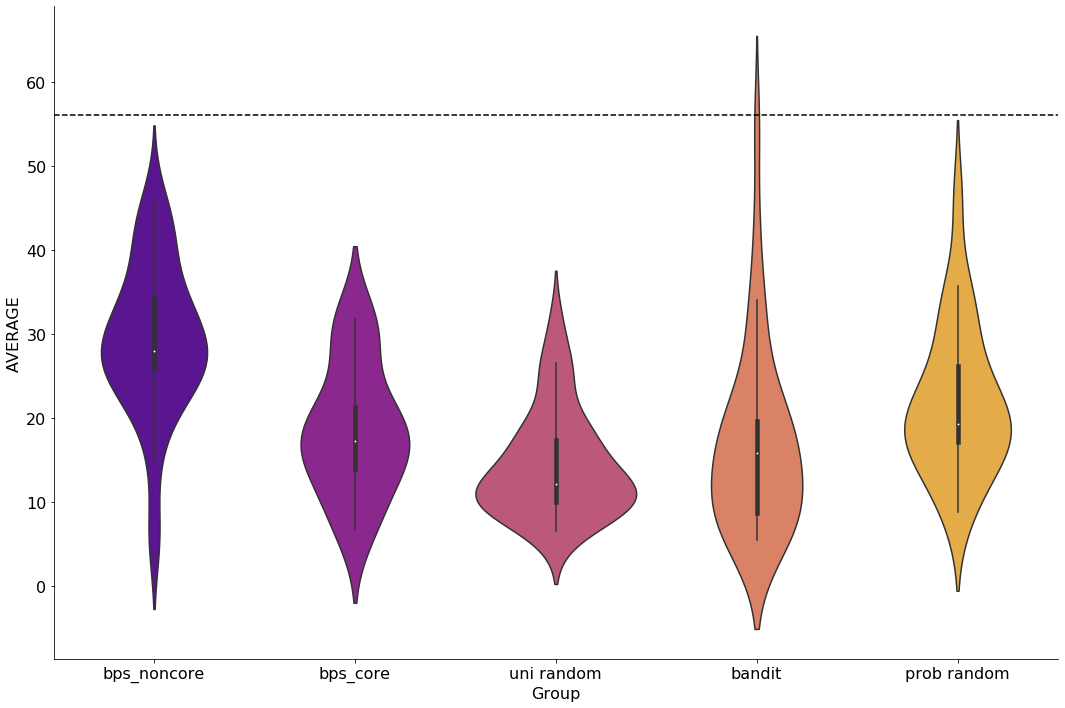

In [18]:
fig, ax = plt.subplots( figsize=(18,12))
plt.axhline(56.058,color="black",ls="--")
sns.violinplot(x="Group", y="AVERAGE", data=df.drop([0]),palette='plasma')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#dfv = df.copy(deep=True)

#for index, row in dfv.iterrows():
#    if row['Group'] == 'bps' and row['RBS6'] == 'AGGAGA':
#        row['Group'] = 'bps_ncore'
#        dfv = dfv.append(row, ignore_index=True)
#    elif row['Group'] == 'bps' and row['RBS6'] != 'AGGAGA':
#        row['Group'] = 'bps_core'
#        dfv = dfv.append(row, ignore_index=True)      
        
#dfv.sort_values(by = ['Group'], ascending = True,inplace=True) 

#dfv.head(300)

#fig, ax = plt.subplots( figsize=(18,12))
#sns.violinplot(x="Group", y="AVERAGE", data=dfv,palette='viridis')

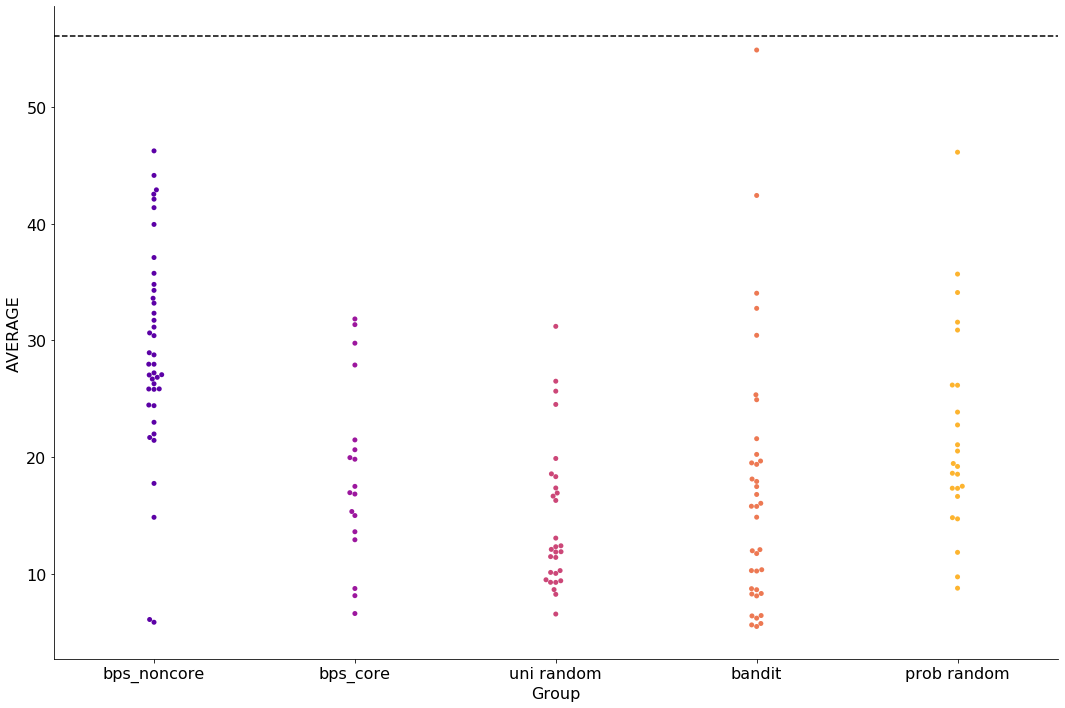

In [20]:
fig, ax = plt.subplots( figsize=(18,12))
plt.axhline(56.058,color="black",ls="--")
sns.swarmplot(x="Group", y="AVERAGE", data=df.drop([0]),palette='plasma')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Violinplot with all replications

In [13]:
df_all_rep = pd.melt(df, id_vars=['RBS', 'Group'], value_vars=['Rep1', 'Rep2', 'Rep3'])
df_all_rep = df_all_rep.dropna()

In [14]:
df_all_rep.sort_values(by = ['value'], ascending = False).head(10)

,RBS,Group,variable,value
415,TTTAAGACTTTTTTATACAT,bandit,Rep3,61.284187
115,TTTAAGACTTTTTTATACAT,bandit,Rep1,54.782242
150,TTTAAGAAGGAGATATACAT,reference,Rep2,52.402431
445,TTTAAGATAGTCTTATACAT,prob random,Rep3,48.668344
265,TTTAAGACTTTTTTATACAT,bandit,Rep2,48.489185
145,TTTAAGATAGTCTTATACAT,prob random,Rep1,46.329777
154,TCTAAGAAGGAGATATACAT,bps_noncore,Rep2,45.913214
160,TTTGAGAAGGAGATATACAT,bps_noncore,Rep2,44.897779
197,TTTAAGAAGGAGATAAACAT,bps_noncore,Rep2,43.377297
295,TTTAAGATAGTCTTATACAT,prob random,Rep2,43.329749


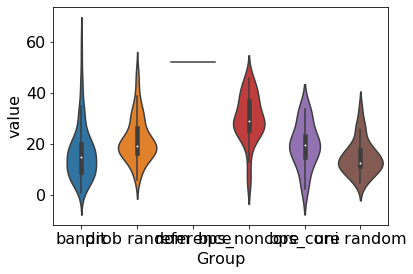

In [15]:
sns.violinplot(x="Group", y="value", data=df_all_rep)

## Predict labels with baseline data as training data

In [16]:
df.sort_values(by = ['AVERAGE'], ascending = False).head(10)

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,AVERAGE,STD
0,0,RBS_1by1_0,reference,TTTAAGAAGGAGATATACAT,AGGAGA,NaN,52.402431,NaN,61.622165,54.151485,56.058694,3.998246
115,138,RBS_BA_48,bandit,TTTAAGACTTTTTTATACAT,CTTTTT,54.782242,48.489185,61.284187,NaN,NaN,54.851871,5.223770
59,60,RBS_1by1_60,bps_noncore,TTTAAGAAGGAGATATACAA,AGGAGA,NaN,43.183173,NaN,47.433874,48.048028,46.221691,2.163137
145,173,RBS_RP_54,prob random,TTTAAGATAGTCTTATACAT,TAGTCT,46.329777,43.329749,48.668344,NaN,NaN,46.109290,2.185042
47,48,RBS_1by1_48,bps_noncore,TTTAAGAAGGAGATAAACAT,AGGAGA,NaN,43.377297,NaN,49.202630,39.787620,44.122516,3.879615
4,4,RBS_1by1_4,bps_noncore,TCTAAGAAGGAGATATACAT,AGGAGA,NaN,45.913214,NaN,44.352931,38.394865,42.887003,3.239660
1,1,RBS_1by1_1,bps_noncore,CTTAAGAAGGAGATATACAT,AGGAGA,NaN,40.072951,NaN,42.042854,45.432032,42.515946,2.213263
114,137,RBS_BA_47,bandit,TTTAAGAGTTTTTTATACAT,GTTTTT,42.834915,41.799990,42.584558,NaN,NaN,42.406488,0.440870
10,11,RBS_1by1_11,bps_noncore,TTTGAGAAGGAGATATACAT,AGGAGA,NaN,44.897779,NaN,42.063149,39.304470,42.088466,2.283529
7,8,RBS_1by1_8,bps_noncore,TTGAAGAAGGAGATATACAT,AGGAGA,NaN,40.197744,NaN,45.233411,38.655693,41.362283,2.808761


In [17]:
lm = sns.violinplot(x="Group", y="predict mean", data=df)
axes = lm.axes
axes.set_ylim(-2,4)

ValueError: Could not interpret input 'predict mean'

In [ ]:
sns.violinplot(x="Group", y="value", data=df_all_rep)